<a href="https://colab.research.google.com/github/WangXizhuo/coding-test/blob/main/COMP3316_prepare_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install paddle_quantum
!pip install numpy
# # import packages
import paddle
import numpy as np
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger
from paddle_quantum.state import State
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.9/219.9 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.0/374.0 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 KB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━

/usr/local/lib/python3.9/dist-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/usr/local/lib/python3.9/dist-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [3]:
def circuit(N, DEPTH):
    """
    Input data:
         N,         qubits number
         DEPTH,     layers number
    Return:
         cir,       the final circuit
    """
    # step 1.1: Create an N qubit circuit
    cir = Circuit(N)
    # step 1.2: Add gates to each layer
    for dep in range(DEPTH):
        for n in range(N):
            cir.rx(n)  # add an Rx gate to the n-th qubit
            # cir.ry(n)  # add an Rx gate to the n-th qubit
            cir.rz(n)  # add an Rz gate to the n-th qubit
        for n in range(N-1):
            cir.cnot([n, n + 1])  # add CNOT gate to every neighbor pair
    return cir

In [ ]:
N = 3
DEPTH = 2
cir = circuit(N, DEPTH) # initialized with random theta
print(cir) 

--Rx(1.162)----Rz(1.268)----*----Rx(5.195)----Rz(3.052)---------------------*--------Rx(3.536)----Rz(3.299)---------------------*--------Rx(1.887)----Rz(5.832)---------------------*--------Rx(4.096)----Rz(2.088)---------------------*-----------------------------
                            |                                               |                                                   |                                                   |                                                   |                             
--Rx(1.763)----Rz(1.438)----x--------*--------Rx(3.750)----Rz(2.164)--------x------------*--------Rx(0.339)----Rz(4.735)--------x------------*--------Rx(1.986)----Rz(3.403)--------x------------*--------Rx(5.347)----Rz(5.818)--------x------------*----------------
                                     |                                                   |                                                   |                                                   |                 

In [4]:
def loss_func(cir: Circuit, psi: State) -> paddle.Tensor:
    final_state = cir().data
    psi_target = psi.data
    inner = paddle.matmul(dagger(final_state), psi_target)
    loss = -paddle.real(paddle.matmul(dagger(inner), inner))
    return loss

In [ ]:
N = 3
DEPTH = 2
cir = circuit(N, DEPTH)
ITR = 100    # iteration number
LR = 0.2   # learning rate

# The target state 
psi_vec = np.kron(np.kron(np.array([[1],[0]]), np.array([[0], [1]])), np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]]))

# Convert the target state to a State
psi_target = State(paddle.to_tensor(psi_vec).cast('complex64'))

# Record the loss in each iteration:
loss_list = []

# use Adam optimizer
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = cir.parameters())

# Optimize during iteration
for itr in range(ITR):
    # Calculate the loss
    loss = loss_func(cir, psi_target)
    # Backward optimize via Gradient descent algorithm
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # Record the learning curve
    loss_list.append(loss.numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())

iter: 0   loss: -0.0142
iter: 10   loss: -0.8599
iter: 20   loss: -0.9108
iter: 30   loss: -0.9972
iter: 40   loss: -0.9897
iter: 50   loss: -0.9964
iter: 60   loss: -0.9998
iter: 70   loss: -0.9998
iter: 80   loss: -0.9998
iter: 90   loss: -0.9999


In [ ]:
psi_vec, cir().data # dagger of a ket is its bra

(array([0.05305965, 0.00866172, 0.00866824, ..., 0.00536232, 0.03084585,
        0.05093059]),
 Tensor(shape=[1024], dtype=complex64, place=Place(cpu), stop_gradient=False,
        [(0.02871686778962612-0.0027935451362282038j) ,
         (0.029781939461827278-0.002938721561804414j) ,
         (0.03112160600721836-0.002967224922031164j)  ,
         ...,
         (0.03138867765665054-0.0029243608005344868j) ,
         (0.03003772906959057-0.0028985259123146534j) ,
         (0.028963429853320122-0.0027544593904167414j)]))

In [ ]:
# Print the output
print('The minimum of the loss function: ', loss_list[-1])

# The parameters after optimization
theta_final = [param.numpy() for param in cir.parameters()]
print("Parameters after optimizationL theta:\n", theta_final, "\n")

# Draw the circuit picture and the output state
print(cir)

The minimum of the loss function:  [-0.99998784]
Parameters after optimizationL theta:
 [array([[3.1402774]], dtype=float32), array([[3.1470275]], dtype=float32), array([[6.2847943]], dtype=float32), array([[1.6420169]], dtype=float32), array([[-0.14469518]], dtype=float32), array([[5.686759]], dtype=float32), array([[3.1435096]], dtype=float32), array([[5.910276]], dtype=float32), array([[-0.00704579]], dtype=float32), array([[2.984685]], dtype=float32), array([[4.833617]], dtype=float32), array([[1.4916052]], dtype=float32)] 

--Rx(3.140)----Rz(3.147)----*----Rx(3.144)----Rz(5.910)-----------------*-------
                            |                                           |       
--Rx(6.285)----Rz(1.642)----x--------*--------Rx(-0.00)----Rz(2.985)----x----*--
                                     |                                       |  
--Rx(-0.14)----Rz(5.687)-------------x--------Rx(4.834)----Rz(1.492)---------x--
                                                            

state_final:
 [ 8.9436863e-04-1.7094088e-03j  1.5389855e-03-2.6455927e-03j
  6.5920347e-01+2.5703034e-01j  6.5886879e-01+2.5546801e-01j
 -1.9021682e-06-6.7933172e-04j -5.9945160e-07-6.7691051e-04j
 -4.6651042e-04-3.2612486e-05j  4.5126147e-04+1.0566579e-04j]


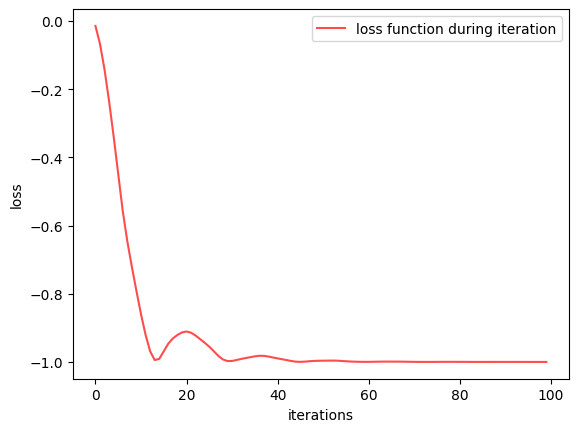

In [ ]:
# Print the final state
state_final = cir()
print("state_final:\n", state_final.data.numpy())

# Print the loss function during iteration
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()

In [5]:
def prepare_state(N, DEPTH, ITR, LR, tar_vec):
  cir = circuit(N, DEPTH)
  tensor_tar = State(paddle.to_tensor(tar_vec).cast('complex64'))
  loss_list = []
  opt = paddle.optimizer.Adam(learning_rate = LR, parameters = cir.parameters())
  for itr in range(ITR):
    loss = loss_func(cir, tensor_tar)
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    loss_list.append(loss.numpy())
  return loss_list, cir
  

In [ ]:
phi_plus = np.kron(np.array([1, 0]), np.array([1, 0])) / np.sqrt(2) + np.kron(np.array([0, 1]), np.array([0, 1])) / np.sqrt(2)
phi_minus = np.kron(np.array([1, 0]), np.array([1, 0])) / np.sqrt(2) - np.kron(np.array([0, 1]), np.array([0, 1])) / np.sqrt(2)
psi_plus = np.kron(np.array([1, 0]), np.array([0, 1])) / np.sqrt(2) + np.kron(np.array([0, 1]), np.array([1, 0])) / np.sqrt(2)
psi_minus = np.kron(np.array([1, 0]), np.array([0, 1])) / np.sqrt(2) - np.kron(np.array([0, 1]), np.array([1, 0])) / np.sqrt(2)
N, D = 2, 2
ITR, LR = 200, 0.1
loss_all, state_name = [], ['phi_plus', 'phi_minus', 'psi_plus', 'psi_minus']
for i, tar_vec in enumerate([phi_plus, phi_minus, psi_plus,psi_minus]):
  np.set_printoptions(precision=2)
  loss_list, cir = prepare_state(N, DEPTH, ITR, LR, tar_vec)
  print(f'Target state {state_name[i]}', tar_vec)
  print('Output', cir().data.numpy())
  loss_all.append(loss_list)

Target state phi_plus [0.71 0.   0.   0.71]
Output [ 5.84e-02+7.05e-01j -1.61e-05-1.13e-05j  1.59e-05-8.68e-06j
  5.84e-02+7.05e-01j]
Target state phi_minus [ 0.71  0.    0.   -0.71]
Output [-7.04e-01-6.90e-02j  8.39e-07-4.16e-05j -5.96e-06-1.04e-05j
  7.04e-01+6.90e-02j]
Target state psi_plus [0.   0.71 0.71 0.  ]
Output [-2.26e-05-1.69e-05j  2.11e-01-6.75e-01j  2.11e-01-6.75e-01j
  7.47e-05-4.73e-05j]
Target state psi_minus [ 0.    0.71 -0.71  0.  ]
Output [ 3.30e-05-9.61e-06j -1.75e-01+6.85e-01j  1.75e-01-6.85e-01j
  3.42e-05-7.54e-06j]


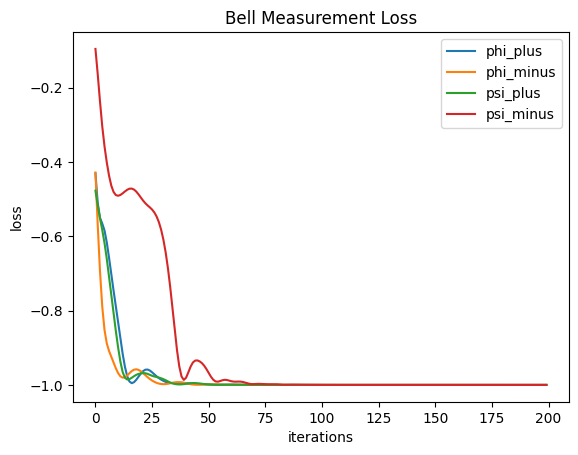

In [ ]:
ITR_list = [i for i in range(ITR)]
plt.figure(1)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Bell Measurement Loss")
for i in range(4):
    plt.plot(ITR_list, loss_all[i], label = state_name[i])
plt.legend()
plt.show()

In [8]:
large_state = np.random.rand(32)
large_state = large_state / np.linalg.norm(large_state) # normalized to unit vector
ITR, N = 500, 5
loss_all = [[], [], [], [], []]
DEPTHs = [i for i in range(3, 11)]
LRs = [0.2, 0.1, 0.05, 0.02, 0.01]
for i, LR in enumerate(LRs):
  for DEPTH in DEPTHs:
    np.set_printoptions(precision=6)
    loss_list, cir = prepare_state(N, DEPTH, ITR, LR, large_state)
    loss_all[i].append(loss_list[-1])
    print(f'Training with depth {DEPTH} and learning rate {LR} reached loss {loss_list[-1]}.')
  


Training with depth 3 and learning rate 0.2 reached loss [-0.879529].
Training with depth 4 and learning rate 0.2 reached loss [-0.959939].
Training with depth 5 and learning rate 0.2 reached loss [-0.977896].
Training with depth 6 and learning rate 0.2 reached loss [-0.99896].
Training with depth 7 and learning rate 0.2 reached loss [-0.99926].
Training with depth 8 and learning rate 0.2 reached loss [-0.999189].
Training with depth 9 and learning rate 0.2 reached loss [-0.999264].
Training with depth 10 and learning rate 0.2 reached loss [-0.999031].
Training with depth 3 and learning rate 0.1 reached loss [-0.879624].
Training with depth 4 and learning rate 0.1 reached loss [-0.940115].
Training with depth 5 and learning rate 0.1 reached loss [-0.989532].
Training with depth 6 and learning rate 0.1 reached loss [-0.99943].
Training with depth 7 and learning rate 0.1 reached loss [-0.999887].
Training with depth 8 and learning rate 0.1 reached loss [-0.999875].
Training with depth 9 